# HCP participants

This is a notebook to explore if component loadings are unquie 

In [1]:
from nfact_id.functions.idp_functions import create_correlation_matrix, create_wide_df
from nfact_id.functions.modelling_fuc import define_rope_width, diagnostics, calculate_effect_size
import pandas as pd
from decouple import config
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bambi as bm
import arviz as az
os.environ["CPATH"] = "/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/v1"

## Get component directory

In [2]:
component_dir = os.path.join(config("base_dir"), "component_loadings", "hcp")

## Pre-process data

participant dr has the same order of df_wide

In [3]:
df_wide = create_wide_df(os.path.join(component_dir, "G_component_loadings.csv"), os.path.join(component_dir, "W_component_loadings.csv"))
participant_info = pd.read_csv(os.path.join(component_dir, "participants_dr.csv"))
df_wide['group'] = participant_info['phenotype']

### Split by group

In [4]:
controls_subjects = df_wide[df_wide['group'].str.contains("Control")]
anxiety_subjects = df_wide[df_wide['group'].str.contains("Anxiety")]
depression_subjects = df_wide[df_wide['group'].str.contains("Depression")]
psychosis_subjects = df_wide[df_wide['group'].str.contains("psychosis")]
group_sizes = [controls_subjects.shape[0], anxiety_subjects.shape[0], depression_subjects.shape[0], psychosis_subjects.shape[0]]

## Create correlation matrices

In [5]:
grey_corr = create_correlation_matrix(df_wide.drop('group', axis=1), "G_")
white_coor = create_correlation_matrix(df_wide.drop('group', axis=1), "W_")

## Plot matrices

In [6]:
def compute_group_stats(mat, group_sizes, group_names):
    """
    Compute mean and std of correlations per group pair 
    (excluding diagonals within groups).

    Returns a tidy DataFrame with columns: [Group1, Group2, Mean, Std].
    """
    records = []


    start_i = 0
    for gi, size_i in enumerate(group_sizes):
        start_j = 0
        for gj, size_j in enumerate(group_sizes):
            block = mat[start_i:start_i+size_i, start_j:start_j+size_j].copy()

            # Exclude diagonals for within-group blocks
            if gi == gj:
                np.fill_diagonal(block, np.nan)

            mean_corr = np.nanmean(block)
            std_corr  = np.nanstd(block)

            records.append({
                "Group1": group_names[gi],
                "Group2": group_names[gj],
                "Mean": mean_corr,
                "Std": std_corr
            })

            start_j += size_j
        start_i += size_i

    return pd.DataFrame.from_records(records)


NameError: name 'group_names' is not defined

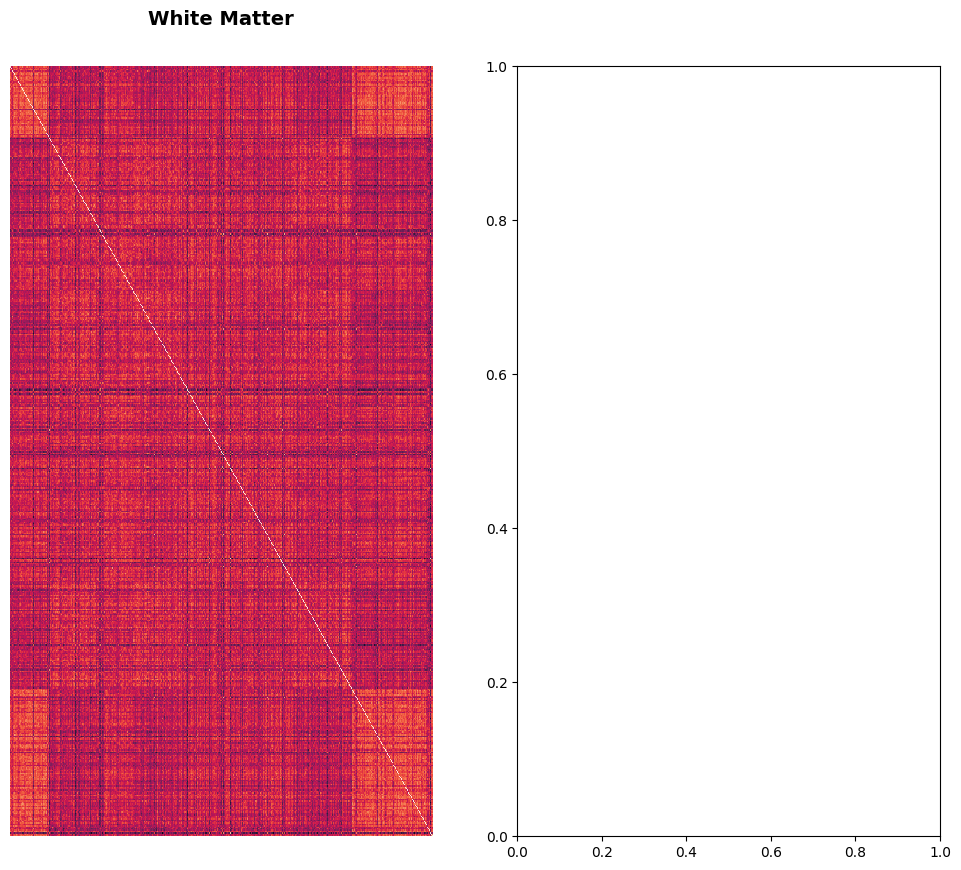

In [7]:
group_descrip = ["Controls", "Anxiety", "Depression", "Psychosis"]
fig, axes = plt.subplots(1, 2, figsize=(12, 10))
boundaries = np.cumsum(group_sizes)
all_data = np.array([white_coor, grey_corr])
vmin = all_data.min()
vmax = all_data.max()
for ax, mat, title in zip(axes, all_data, ["White Matter", "Grey Matter"]):
    sns.heatmap(mat, ax=ax, cbar=False, xticklabels=False, yticklabels=False,vmin=vmin, vmax=vmax)
    ax.set_title(title, fontweight='bold', fontsize=14, pad=30)
    start = 0
    for size, name in zip(group_sizes, group_names):
        center = start + size / 2
        ax.text(center, -0.5, name, ha="center", va="bottom", fontsize=10, fontweight="bold")
        ax.text(-0.5, center, name, ha="right", va="center", fontsize=10, fontweight="bold", rotation=90)
        start += size
        
    for bound in boundaries[:-1]:  # don't draw line after last group
        ax.axhline(bound, color='black', lw=2)
        ax.axvline(bound, color='black', lw=2)
    

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  
sns.heatmap(white_coor, ax=axes[0], cbar=True, vmin=vmin, vmax=vmax,
            cbar_ax=cbar_ax, xticklabels=False, yticklabels=False)

fig.subplots_adjust(left=0.001, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)
plt.show()

## Get individual group break downs

In [8]:
white_means = compute_group_stats(white_coor.values, group_sizes, ["Controls", "Anxiety", "Depression", "Psychosis"])
grey_means = compute_group_stats(grey_corr.values, group_sizes, ["Controls", "Anxiety", "Depression", "Psychosis"])

In [9]:
white_means

,Group1,Group2,Mean,Std
0,Controls,Controls,0.340207,0.135204
1,Controls,Anxiety,0.327646,0.130290
2,Controls,Depression,0.330724,0.130099
3,Controls,Psychosis,0.347255,0.148546
4,Anxiety,Controls,0.327646,0.130290
5,Anxiety,Anxiety,0.357262,0.125248
6,Anxiety,Depression,0.338252,0.129609
7,Anxiety,Psychosis,0.279759,0.123888
8,Depression,Controls,0.330724,0.130099
9,Depression,Anxiety,0.338252,0.129609


In [11]:
grey_means

,Group1,Group2,Mean,Std
0,Controls,Controls,0.846961,0.039178
1,Controls,Anxiety,0.852906,0.036689
2,Controls,Depression,0.850429,0.035985
3,Controls,Psychosis,0.832017,0.039438
4,Anxiety,Controls,0.852906,0.036689
5,Anxiety,Anxiety,0.860588,0.031932
6,Anxiety,Depression,0.856097,0.031962
7,Anxiety,Psychosis,0.834405,0.038242
8,Depression,Controls,0.850429,0.035985
9,Depression,Anxiety,0.856097,0.031962


## Individual test

### Preprocess data

In [12]:
long_df = pd.melt(df_wide, id_vars=['subject', 'group'], var_name='component', value_name='value')
long_df['component_num'] = long_df['component'].str.extract(r'(\d+)').astype(int)
long_df = long_df.sort_values(by=['subject', 'component_num'])
long_df['comp_type'] = long_df['component'].apply(lambda x: 'Grey' if 'G_' in x else 'White')
long_df = long_df.drop(columns='component').reset_index(drop=True)

### Split by component

In [13]:
white_df = long_df[long_df['comp_type'].str.contains("White")].reset_index(drop=True)
grey_df = long_df[long_df['comp_type'].str.contains("Grey")].reset_index(drop=True)

### The models

Due to bad ess bulk on the intercept the white model has a longer draw and tune

In [14]:
grey_model = bm.Model("value ~ (1|subject)", 
                       data=grey_df,   
                       family="beta",
                       categorical=['subject', 'group'])
white_model = bm.Model("value ~ (1|subject)", 
                       data=white_df,   
                       family="beta",
                       categorical=['subject', 'group'], 
)
null_grey = bm.Model("value ~ 1", 
                       data=grey_df,   
                       family="beta",
                       categorical=['subject'])
null_white = bm.Model("value ~ 1", 
                       data=grey_df,   
                       family="beta",
                       categorical=['subject'])

In [15]:
white_model

       Formula: value ~ (1|subject)
        Family: beta
          Link: mu = logit
  Observations: 55800
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            1|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))
        
        Auxiliary parameters
            kappa ~ HalfCauchy(beta: 1.0)

In [16]:
idata_white_model = white_model.fit(tune=2000, draw=2000, cores=10, chains=4, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})

KeyboardInterrupt: 

In [ ]:
az.summary(idata_white_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.729,0.001,0.727,0.731,0.0,0.0,416.0,917.0,1.01
value_sigma,0.086,0.000,0.085,0.086,0.0,0.0,4975.0,2939.0,1.00
1|subject_sigma,0.027,0.001,0.026,0.029,0.0,0.0,751.0,1441.0,1.00
1|subject[1006],0.004,0.009,-0.012,0.019,0.0,0.0,4448.0,2599.0,1.00
1|subject[1009],-0.009,0.008,-0.025,0.006,0.0,0.0,4114.0,2586.0,1.00
...,...,...,...,...,...,...,...,...,...
1|subject[s0201],-0.084,0.008,-0.099,-0.069,0.0,0.0,4621.0,3019.0,1.00
1|subject[s0203],0.027,0.008,0.012,0.044,0.0,0.0,4777.0,2769.0,1.00
1|subject[s0205],0.016,0.008,0.001,0.031,0.0,0.0,4917.0,2890.0,1.00
1|subject[s0208],-0.027,0.008,-0.041,-0.011,0.0,0.0,4613.0,2833.0,1.00


In [ ]:
grey_model

       Formula: value ~ (1|subject)
        Family: gaussian
          Link: mu = identity
  Observations: 55800
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.7239710566675479, sigma: 0.33987019299467464)
        
        Group-level effects
            1|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.33987019299467464))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.13594807719786986)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
idata_grey_model = grey_model.fit(tune=2000, draw=2000, cores=10, chains=4, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_sigma, Intercept, 1|subject_sigma, 1|subject_offset]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 137 seconds.


In [175]:
az.summary(idata_grey_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.724,0.001,0.723,0.725,0.0,0.0,2960.0,2962.0,1.0
value_sigma,0.136,0.000,0.135,0.136,0.0,0.0,6283.0,2528.0,1.0
1|subject_sigma,0.011,0.001,0.009,0.012,0.0,0.0,1875.0,2848.0,1.0
1|subject[1006],-0.005,0.008,-0.021,0.009,0.0,0.0,6740.0,3107.0,1.0
1|subject[1009],-0.002,0.008,-0.018,0.014,0.0,0.0,7836.0,3212.0,1.0
...,...,...,...,...,...,...,...,...,...
1|subject[s0201],-0.010,0.008,-0.026,0.005,0.0,0.0,5461.0,3359.0,1.0
1|subject[s0203],0.001,0.009,-0.016,0.016,0.0,0.0,5332.0,2568.0,1.0
1|subject[s0205],0.007,0.009,-0.009,0.022,0.0,0.0,5846.0,3086.0,1.0
1|subject[s0208],-0.010,0.008,-0.025,0.006,0.0,0.0,7215.0,2881.0,1.0


In [199]:
null_white

       Formula: value ~ 1
        Family: gaussian
          Link: mu = identity
  Observations: 55800
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.7239710566675479, sigma: 0.33987019299467464)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.13594807719786986)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [198]:
null_grey

       Formula: value ~ 1
        Family: gaussian
          Link: mu = identity
  Observations: 55800
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.7239710566675479, sigma: 0.33987019299467464)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.13594807719786986)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [176]:
idata_null_grey = null_grey.fit(tune=3000, draw=3000, cores=10, chains=4, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})
idata_null_white = null_white.fit(tune=3000, draw=3000, cores=10, chains=4, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_sigma, Intercept]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 31 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_sigma, Intercept]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 31 seconds.


In [177]:
az.summary(idata_null_white)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.724,0.001,0.723,0.725,0.0,0.0,2488.0,2011.0,1.0
value_sigma,0.136,0.000,0.135,0.137,0.0,0.0,2185.0,2098.0,1.0


In [178]:
az.summary(idata_null_grey)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.724,0.001,0.723,0.725,0.0,0.0,2488.0,2011.0,1.0
value_sigma,0.136,0.000,0.135,0.137,0.0,0.0,2185.0,2098.0,1.0


### Save Models

In [179]:
model_dict = {"Full White model": idata_white_model, "Null White Model": idata_null_white, "Full Grey model": idata_grey_model, "Null Grey Model": idata_null_grey }

In [180]:
for model in model_dict.keys():
    file_name = "_".join(model.split())
    model_dict[model].to_netcdf((os.path.join(component_dir, f"{file_name}.nc")))

## Plot posteriors

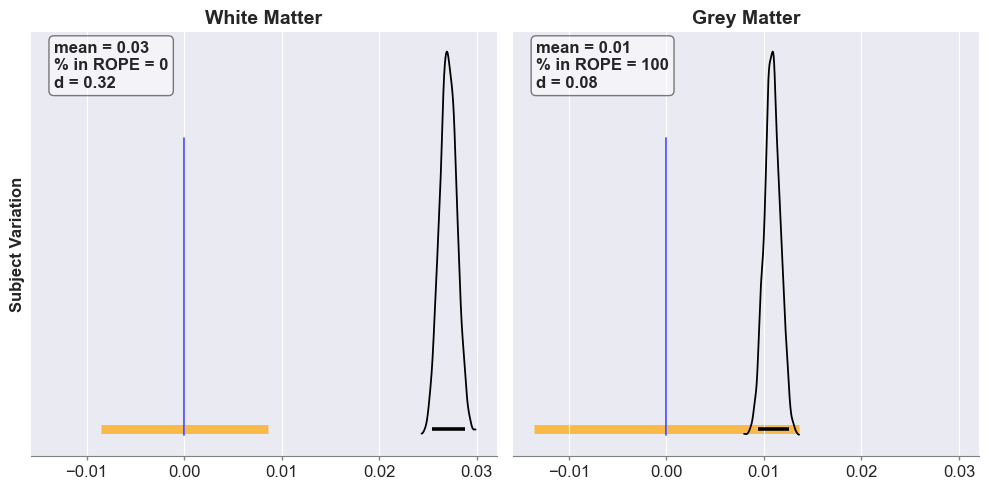

In [197]:
data_key = ['Full White model', 'Full Grey model']
titles = ["White Matter", "Grey Matter"]
params = ['1|subject_sigma']
param_titles = ["Subject Variation"]
sns.set_style("darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

for col, (model_key, title) in enumerate(zip(data_key, titles)):
    model = model_dict[model_key]
    rope_width = define_rope_width(model.posterior['value_sigma'])

    for param, ptitle in zip(params, param_titles):
        ax = axes[col]
        az.plot_posterior(
            model.posterior[param],
            hdi_prob=0.95,
            rope=[-rope_width, rope_width],
            ax=ax,
            textsize=12,   # keep this to avoid breaking plot
            ref_val=0,
            color="black",
            rope_color="orange",
            ref_val_color='blue'
        )
        ax.set_title("")
        if col == 0:
            ax.set_ylabel(ptitle, fontsize=12, fontweight='bold')
        axes[col].set_title(title, fontweight='bold', fontsize=14)

        for txt in list(ax.texts):
            txt.remove()

        mean_val = model.posterior[param].mean().item()
        rope_pct = 100 * ((model.posterior[param] > -rope_width) & 
                          (model.posterior[param] < rope_width)).mean().item()
        effect_size = calculate_effect_size(mean_val, model.posterior['value_sigma'].mean().item())

        box_text = f"mean = {mean_val:.2f}\n% in ROPE = {rope_pct:.0f}\nd = {effect_size:.2f}"

        # add it in the top-left corner
        ax.text(
            0.05, 0.98,  # axes coordinates
            box_text,
            transform=ax.transAxes,
            ha="left",
            va="top",
            fontsize=12,
            fontweight="bold",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="black", boxstyle="round,pad=0.3")
        )

plt.tight_layout()
plt.show()

In [200]:
comparison = az.compare(model_dict)

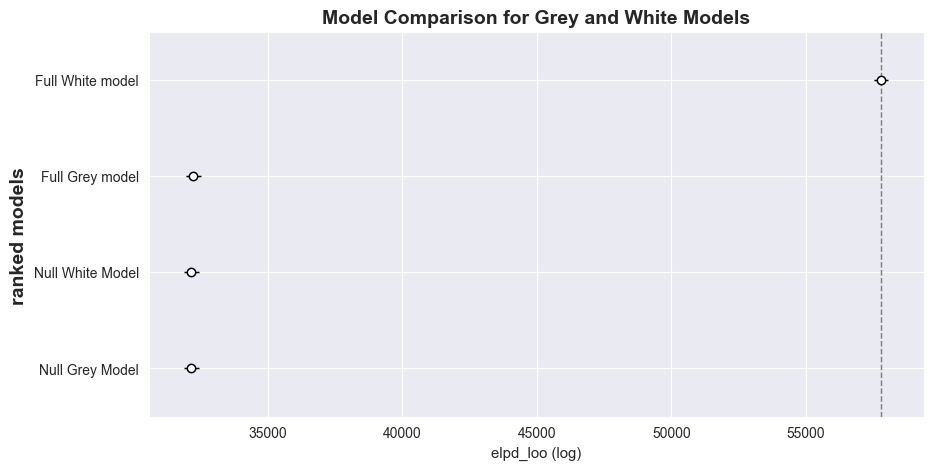

In [201]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
az.plot_compare(comparison,ax=axes, textsize=10)
axes.set_title("Model Comparison for Grey and White Models", fontsize=14, fontweight="bold")
ylabel = axes.yaxis.label
ylabel.set_horizontalalignment('right')  # keep it aligned nicely
ylabel.set_position((-0.1, 0.65))        # x moves left, y=0.5 centers vertically
ylabel.set_fontsize(14)
ylabel.set_fontweight("bold")
plt.show()